In [2]:
import pandas as pd

# Load dataset
file_path = "E:/NLP(Sentimate analysis project)/245_1.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews.date          70977 non-null  object 
 11  reviews.dateAdded     71044 non-null  object 
 12  reviews.dateSeen      71044 non-null  object 
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id         

In [3]:
# Keep relevant columns
df = df[['reviews.text', 'reviews.rating', 'reviews.numHelpful']].dropna()

# Convert ratings to sentiment categories
def assign_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(assign_sentiment)

# Define fake reviews: Reviews with zero helpful votes are considered fake
df['is_fake'] = df['reviews.numHelpful'].fillna(0).apply(lambda x: 1 if x == 0 else 0)

df.head()


,reviews.text,reviews.rating,reviews.numHelpful,sentiment,is_fake
0,i love this album. it's very good. more to the...,5,0.0,Positive,1
30,"yes, the scent is the best. if you like lemon ...",5,1.0,Positive,0
35,"I love this lotion. Nice and thick, great frag...",5,0.0,Positive,1
36,Not sure how this works with clearing your com...,4,3.0,Positive,0
37,Makes my skin feel clean and not super dry whe...,5,1.0,Positive,0


In [4]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HELLO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) if stopwords.words('english') else set(["the", "is", "in", "and", "to", "a"])


In [6]:
import spacy

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

def clean_text_spacy(text):
    doc = nlp(text.lower())  # Convert to lowercase and process with SpaCy
    words = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Lemmatize and remove stopwords
    return ' '.join(words)

# Apply to dataset
df['cleaned_review_spacy'] = df['reviews.text'].astype(str).apply(clean_text_spacy)
df[['reviews.text', 'cleaned_review_spacy']].head()


,reviews.text,cleaned_review_spacy
0,i love this album. it's very good. more to the...,love album good hip hop current pop sound hype...
30,"yes, the scent is the best. if you like lemon ...",yes scent good like lemon frost will able loti...
35,"I love this lotion. Nice and thick, great frag...",love lotion nice thick great fragrance use han...
36,Not sure how this works with clearing your com...,sure work clear complexion week skin smooth clean
37,Makes my skin feel clean and not super dry whe...,make skin feel clean super dry ashy not follow...


In [7]:
import re

def clean_text_regex(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply to dataset
df['cleaned_review'] = df['reviews.text'].astype(str).apply(clean_text_regex)
df[['reviews.text', 'cleaned_review']].head()


,reviews.text,cleaned_review
0,i love this album. it's very good. more to the...,i love this album it s very good more to the h...
30,"yes, the scent is the best. if you like lemon ...",yes the scent is the best if you like lemon fr...
35,"I love this lotion. Nice and thick, great frag...",i love this lotion nice and thick great fragra...
36,Not sure how this works with clearing your com...,not sure how this works with clearing your com...
37,Makes my skin feel clean and not super dry whe...,makes my skin feel clean and not super dry whe...


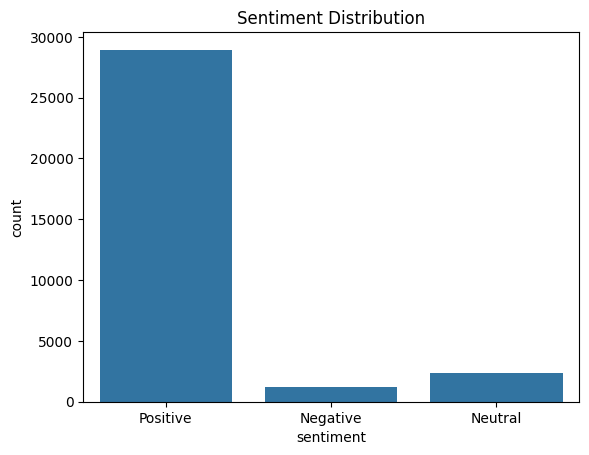

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


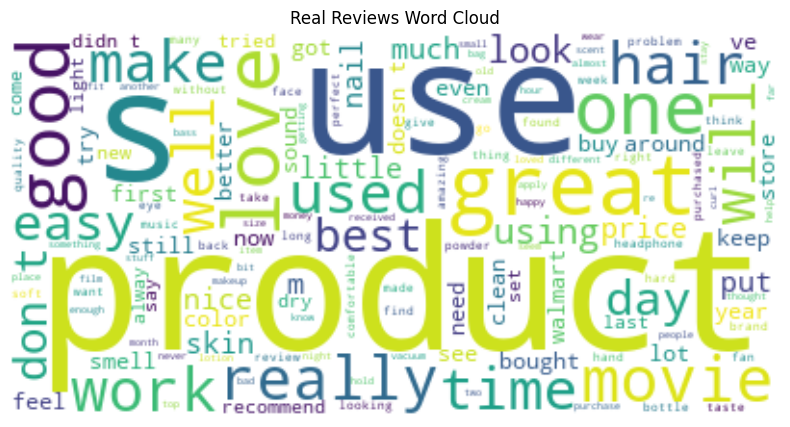

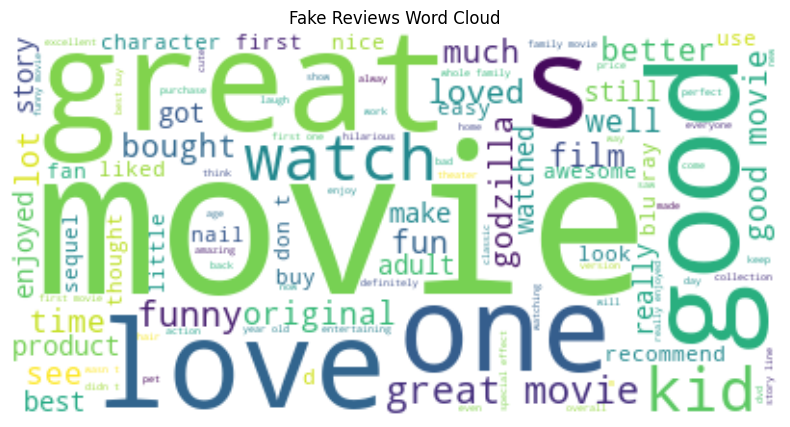

In [9]:
from wordcloud import WordCloud

real_reviews = ' '.join(df[df['is_fake'] == 0]['cleaned_review'])
fake_reviews = ' '.join(df[df['is_fake'] == 1]['cleaned_review'])

plt.figure(figsize=(10, 5))
plt.imshow(WordCloud(background_color="white").generate(real_reviews), interpolation="bilinear")
plt.axis("off")
plt.title("Real Reviews Word Cloud")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(WordCloud(background_color="white").generate(fake_reviews), interpolation="bilinear")
plt.axis("off")
plt.title("Fake Reviews Word Cloud")
plt.show()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])

# Define labels
y_sentiment = df['sentiment']
y_real_fake = df['is_fake']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)


In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate
print("📌 Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


📌 Naive Bayes Accuracy: 0.8858812673023685
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       259
     Neutral       0.10      0.00      0.00       476
    Positive       0.89      1.00      0.94      5767

    accuracy                           0.89      6502
   macro avg       0.33      0.33      0.31      6502
weighted avg       0.79      0.89      0.83      6502



In [12]:
from sklearn.linear_model import LogisticRegression

# Train model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate
print("📌 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


📌 Logistic Regression Accuracy: 0.8960319901568748
              precision    recall  f1-score   support

    Negative       0.74      0.12      0.21       259
     Neutral       0.52      0.16      0.25       476
    Positive       0.91      0.99      0.95      5767

    accuracy                           0.90      6502
   macro avg       0.72      0.43      0.47      6502
weighted avg       0.87      0.90      0.87      6502



In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("📌 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


📌 Random Forest Accuracy: 0.8894186404183329
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.02       259
     Neutral       0.67      0.04      0.08       476
    Positive       0.89      1.00      0.94      5767

    accuracy                           0.89      6502
   macro avg       0.85      0.35      0.35      6502
weighted avg       0.88      0.89      0.84      6502



In [14]:
from sklearn.svm import SVC

# Train model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate
print("📌 SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


📌 SVM Accuracy: 0.8971085819747769
              precision    recall  f1-score   support

    Negative       0.81      0.15      0.25       259
     Neutral       0.63      0.12      0.20       476
    Positive       0.90      0.99      0.95      5767

    accuracy                           0.90      6502
   macro avg       0.78      0.42      0.47      6502
weighted avg       0.88      0.90      0.86      6502



In [15]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

print("📌 LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))


e:\python\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93867
[LightGBM] [Info] Number of data points in the train set: 26004, number of used features: 1907
[LightGBM] [Info] Start training from score -3.350366
[LightGBM] [Info] Start training from score -2.605404
[LightGBM] [Info] Start training from score -0.115349
📌 LightGBM Accuracy: 0.8960319901568748


e:\python\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    
    ('lgb', lgb_model),
    ('rf', rf_model),
    ('svm', svm_model)
], voting='hard')

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

print("📌 Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred_voting))



e:\python\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93867
[LightGBM] [Info] Number of data points in the train set: 26004, number of used features: 1907
[LightGBM] [Info] Start training from score -3.350366
[LightGBM] [Info] Start training from score -2.605404
[LightGBM] [Info] Start training from score -0.115349


e:\python\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📌 Voting Classifier Accuracy: 0.8951091971701015

📌 Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.11      0.19       259
     Neutral       0.66      0.09      0.16       476
    Positive       0.90      1.00      0.94      5767

    accuracy                           0.90      6502
   macro avg       0.78      0.40      0.43      6502
weighted avg       0.88      0.90      0.86      6502



In [18]:
try:
    print("✅ Logistic Regression Model Exists:", lr_model)
    print("✅ Random Forest Model Exists:", rf_model)
    print("✅ SVM Model Exists:", svm_model)
    print("✅ LightGBM Model Exists:", lgb_model)
    print("✅ CatBoost Model Exists:", cat_model)
except NameError as e:
    print("❌ Missing Model:", e)


✅ Logistic Regression Model Exists: LogisticRegression(max_iter=500)
✅ Random Forest Model Exists: RandomForestClassifier(random_state=42)
✅ SVM Model Exists: SVC(kernel='linear')
✅ LightGBM Model Exists: LGBMClassifier()
❌ Missing Model: name 'cat_model' is not defined


In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [20]:
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")


In [21]:
# Store all models and their predictions
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "LightGBM": lgb_model,
    "Voting Classifier": voting_model
}

# Print accuracy and classification report for each model
model_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)  # Convert to dictionary
    model_results[name] = {
        "Accuracy": round(accuracy, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": round(report["weighted avg"]["f1-score"], 4)
    }


In [22]:
import pandas as pd

# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index')

# Sort by Accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Display table
print("\n📌 Final Model Comparison (Without XGBoost)\n")
print(results_df)



📌 Final Model Comparison (Without XGBoost)

                     Accuracy  Precision  Recall  F1-Score
SVM                    0.8971     0.8778  0.8971    0.8637
Logistic Regression    0.8960     0.8713  0.8960    0.8663
LightGBM               0.8960     0.8696  0.8960    0.8673
Voting Classifier      0.8951     0.8765  0.8951    0.8575
Random Forest          0.8894     0.8784  0.8894    0.8418


C:\Users\HELLO\AppData\Local\Temp\ipykernel_8416\3642410633.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(results_df.index, rotation=45)
C:\Users\HELLO\AppData\Local\Temp\ipykernel_8416\3642410633.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(results_df.index, rotation=45)
C:\Users\HELLO\AppData\Local\Temp\ipykernel_8416\3642410633.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(results_df.index, rotation=45)
C:\Users\HELLO\AppData\Local\Temp\ipykernel_8416\3642410633.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(results_df.

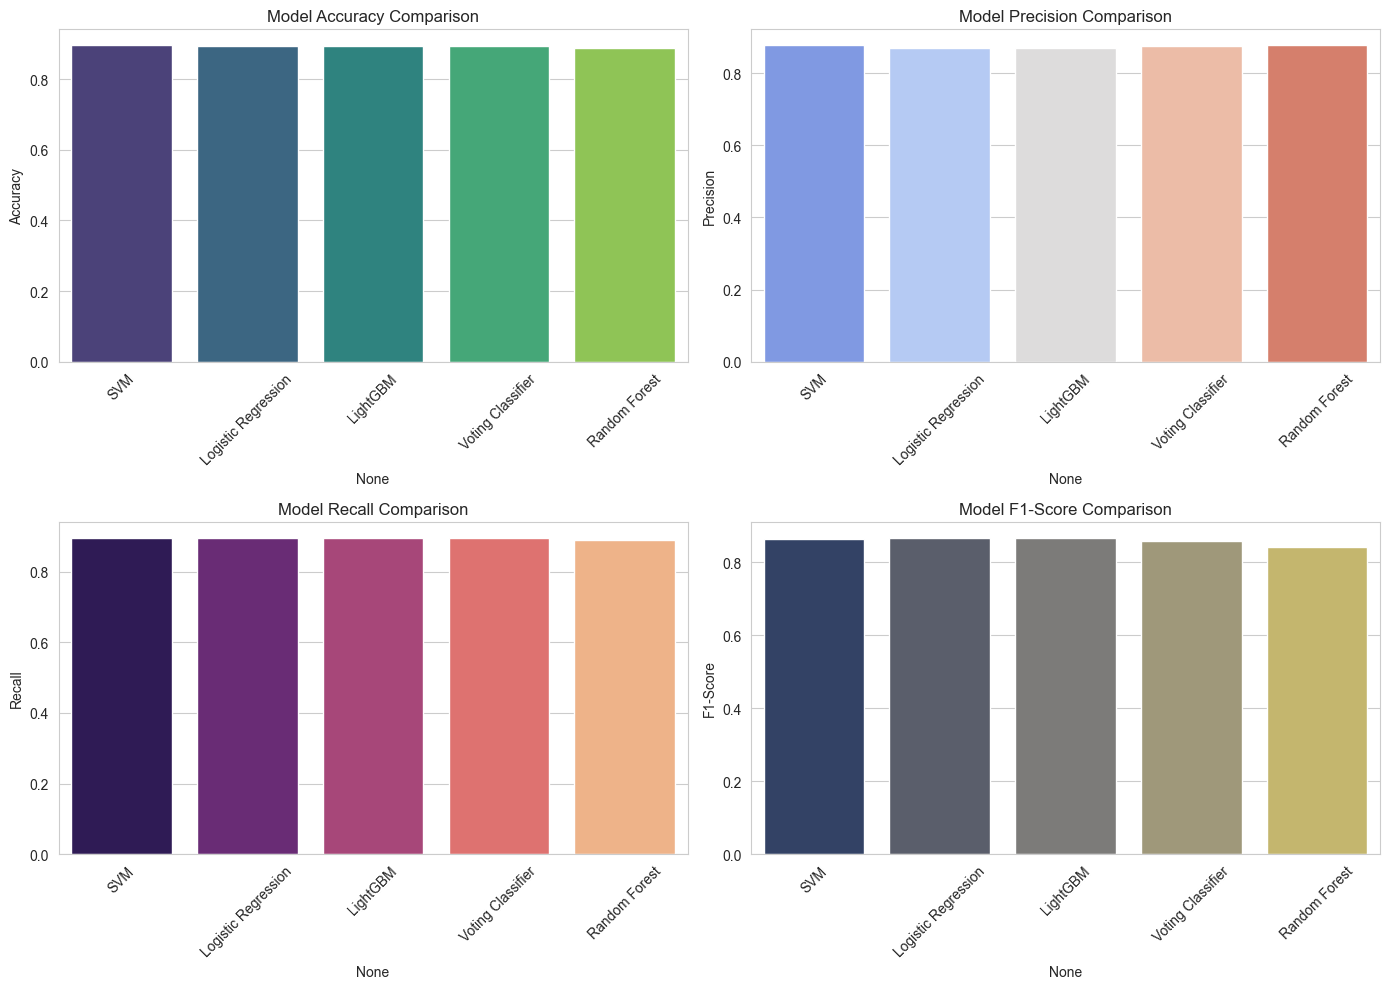

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create a bar plot for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy Comparison
sns.barplot(x=results_df.index, y=results_df["Accuracy"], ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Model Accuracy Comparison")
axes[0, 0].set_xticklabels(results_df.index, rotation=45)

# Precision Comparison
sns.barplot(x=results_df.index, y=results_df["Precision"], ax=axes[0, 1], palette="coolwarm")
axes[0, 1].set_title("Model Precision Comparison")
axes[0, 1].set_xticklabels(results_df.index, rotation=45)

# Recall Comparison
sns.barplot(x=results_df.index, y=results_df["Recall"], ax=axes[1, 0], palette="magma")
axes[1, 0].set_title("Model Recall Comparison")
axes[1, 0].set_xticklabels(results_df.index, rotation=45)

# F1-Score Comparison
sns.barplot(x=results_df.index, y=results_df["F1-Score"], ax=axes[1, 1], palette="cividis")
axes[1, 1].set_title("Model F1-Score Comparison")
axes[1, 1].set_xticklabels(results_df.index, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Store confusion matrices
conf_matrices = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm


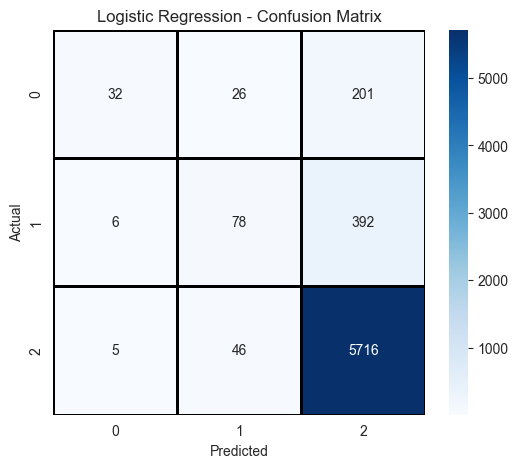

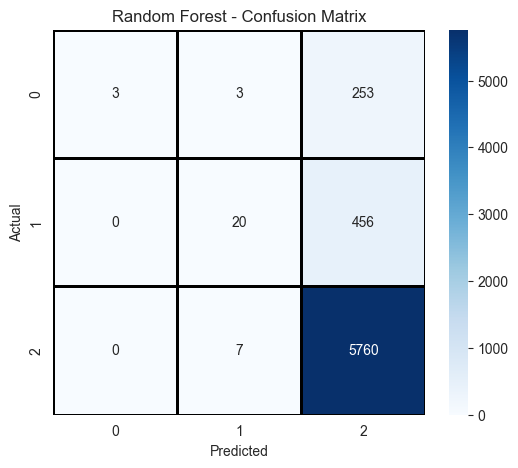

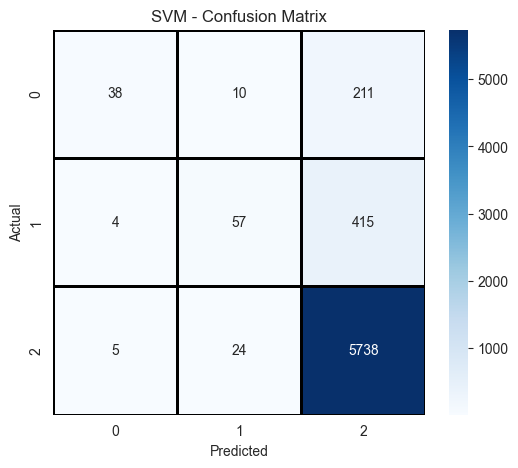

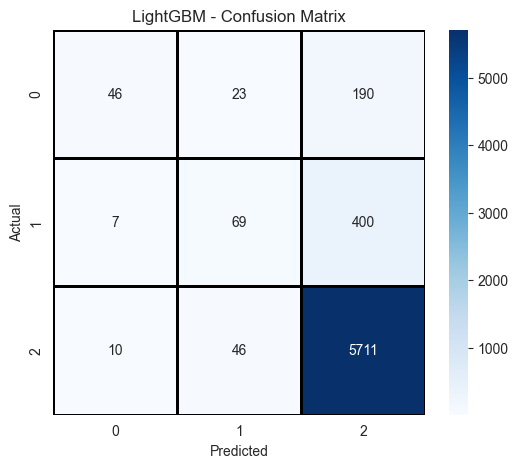

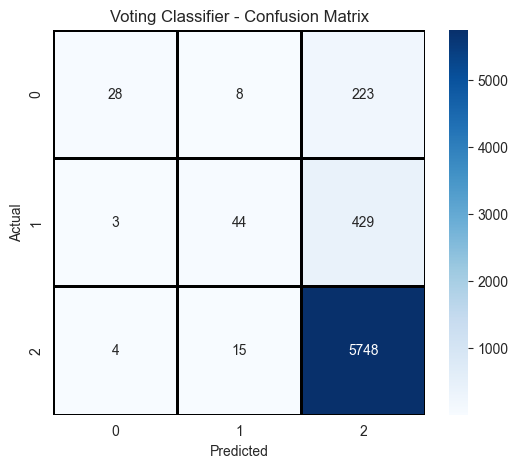

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(model, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Dictionary of models
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "LightGBM": lgb_model,
    "Voting Classifier": voting_model
}

# Plot confusion matrix for each model
for name, model in models.items():
    plot_confusion_matrix(model, name)


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_real_fake, test_size=0.2, random_state=42)

# Train model
fake_review_model = RandomForestClassifier()
fake_review_model.fit(X_train, y_train)

# Predictions
y_pred_fake = fake_review_model.predict(X_test)

# Evaluate model
print(" Random forest Accuracy:", accuracy_score(y_test, y_pred_fake))
print(classification_report(y_test, y_pred_fake))


 Random forest Accuracy: 0.9164872346970163
              precision    recall  f1-score   support

           0       0.70      0.10      0.18       577
           1       0.92      1.00      0.96      5925

    accuracy                           0.92      6502
   macro avg       0.81      0.55      0.57      6502
weighted avg       0.90      0.92      0.89      6502



In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from collections import Counter

# Assuming X and y_real_fake are your feature set and target labels
# X = feature set (e.g., vectorized text), y_real_fake = target labels (e.g., 0 for fake, 1 for genuine)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_real_fake, test_size=0.2, random_state=42)

# Train model
fake_review_model = RandomForestClassifier()
fake_review_model.fit(X_train, y_train)

# Predictions
y_pred_fake = fake_review_model.predict(X_test)

# Evaluate model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_fake))
print(classification_report(y_test, y_pred_fake))

# Count fake and genuine reviews in the predictions
fake_reviews_count = Counter(y_pred_fake)[0]  # Assuming 0 is fake
genuine_reviews_count = Counter(y_pred_fake)[1]  # Assuming 1 is genuine
total_reviews = len(y_pred_fake)  # Total number of reviews

print(f"Total Reviews: {total_reviews}")
print(f"Number of Fake Reviews: {fake_reviews_count}")
print(f"Number of Genuine Reviews: {genuine_reviews_count}")


Random Forest Accuracy: 0.9186404183328206
              precision    recall  f1-score   support

           0       0.76      0.12      0.21       577
           1       0.92      1.00      0.96      5925

    accuracy                           0.92      6502
   macro avg       0.84      0.56      0.58      6502
weighted avg       0.91      0.92      0.89      6502

Total Reviews: 6502
Number of Fake Reviews: 92
Number of Genuine Reviews: 6410


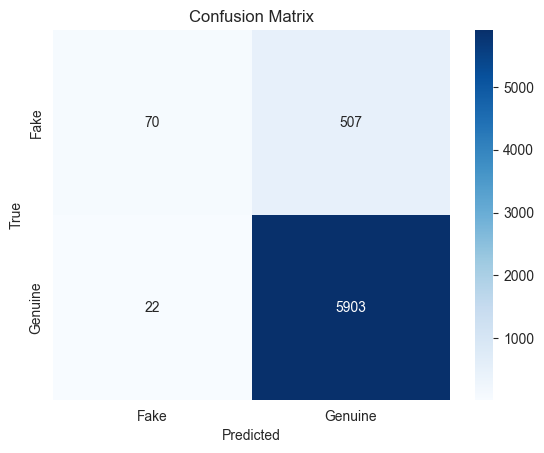

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_fake)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


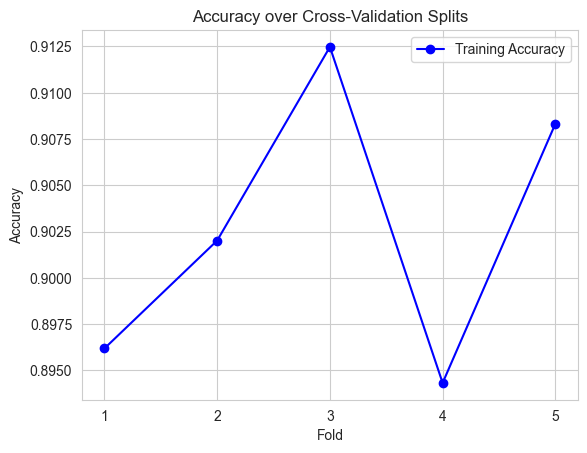

Average Accuracy over Cross-Validation: 90.27%


In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assuming X and y_real_fake are your features and target labels
# X = feature set (e.g., vectorized text), y_real_fake = target labels (e.g., 0 for fake, 1 for genuine)

# Initialize Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use cross-validation to get accuracy across different splits
train_accuracies = cross_val_score(model, X, y_real_fake, cv=5, scoring='accuracy')  # 5-fold cross-validation

# Plotting the accuracy across the cross-validation folds
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.title('Accuracy over Cross-Validation Splits')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies) + 1))
plt.legend()
plt.show()

# If you want to display average accuracy across all splits:
avg_accuracy = np.mean(train_accuracies)
print(f'Average Accuracy over Cross-Validation: {avg_accuracy * 100:.2f}%')


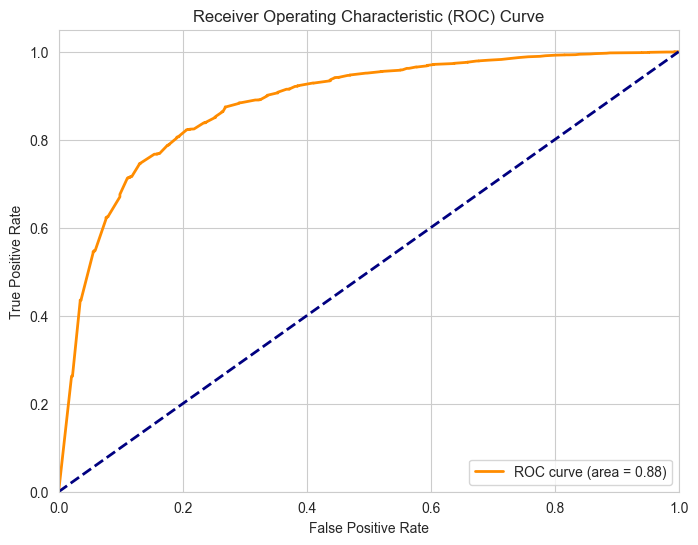

In [30]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, fake_review_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


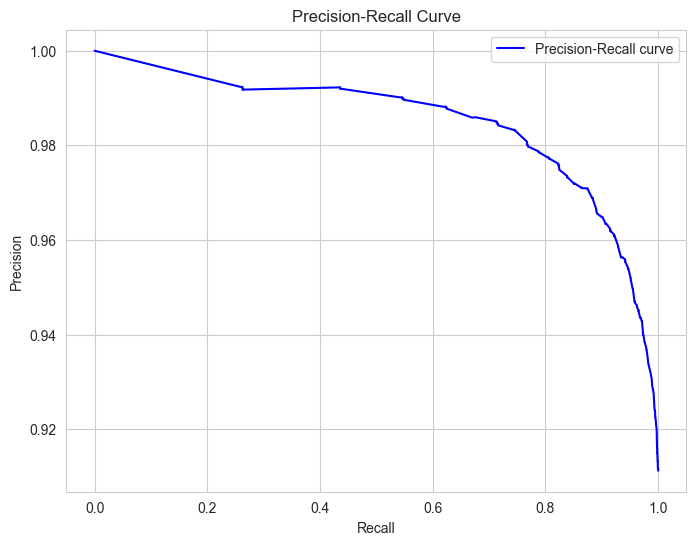

In [31]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, fake_review_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


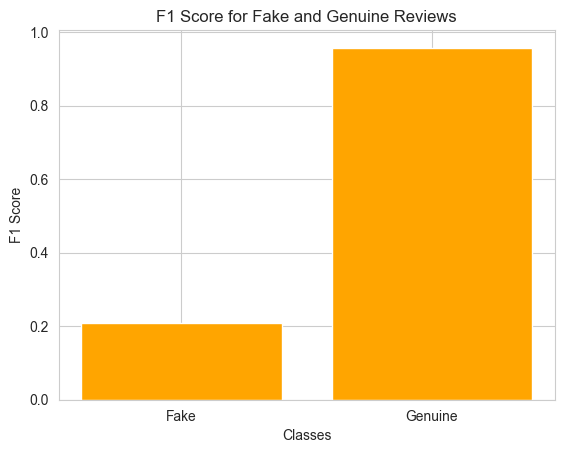

In [32]:
from sklearn.metrics import f1_score

# F1 Score for each class
f1 = f1_score(y_test, y_pred_fake, average=None)
labels = ['Fake', 'Genuine']
plt.bar(labels, f1, color='orange')
plt.title('F1 Score for Fake and Genuine Reviews')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.show()


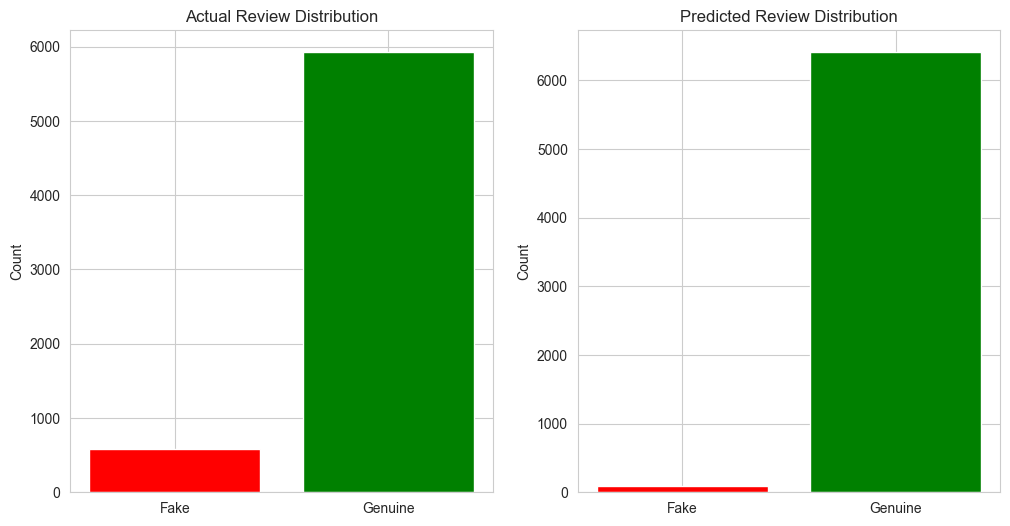

In [33]:
# Bar chart for actual vs predicted classes
actual_counts = Counter(y_test)
predicted_counts = Counter(y_pred_fake)

labels = ['Fake', 'Genuine']
actual_fake = actual_counts[0]
actual_genuine = actual_counts[1]
predicted_fake = predicted_counts[0]
predicted_genuine = predicted_counts[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Actual class distribution
ax[0].bar(labels, [actual_fake, actual_genuine], color=['red', 'green'])
ax[0].set_title('Actual Review Distribution')
ax[0].set_ylabel('Count')

# Predicted class distribution
ax[1].bar(labels, [predicted_fake, predicted_genuine], color=['red', 'green'])
ax[1].set_title('Predicted Review Distribution')
ax[1].set_ylabel('Count')

plt.show()


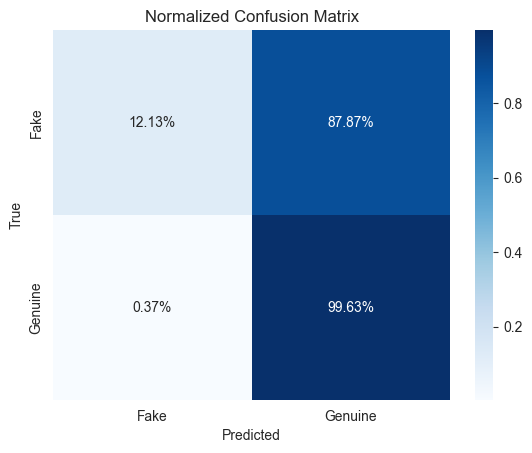

In [34]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


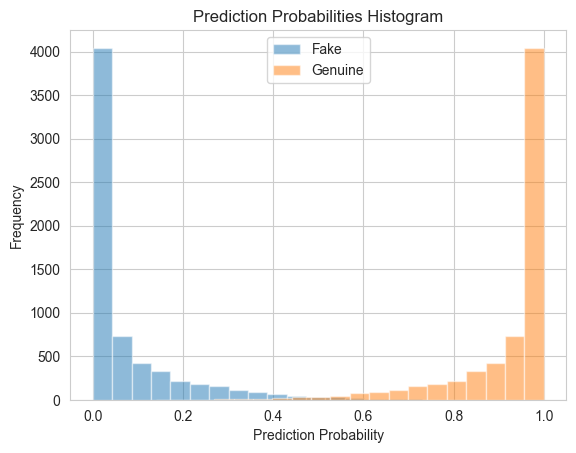

In [37]:
y_probs = fake_review_model.predict_proba(X_test)
plt.hist(y_probs[:, 0], bins=20, alpha=0.5, label='Fake')
plt.hist(y_probs[:, 1], bins=20, alpha=0.5, label='Genuine')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probabilities Histogram')
plt.legend()
plt.show()


In [52]:
import pandas as pd
from IPython.display import display
from sklearn.metrics import accuracy_score

# Calculate the total, fake, and genuine reviews
total_reviews = len(y_test)
fake_reviews = (y_pred_fake == 0).sum()  # Assuming '0' is fake
genuine_reviews = (y_pred_fake == 1).sum()  # Assuming '1' is genuine

# Create a DataFrame for the results
results = pd.DataFrame({
    'Category': ['Total Reviews', 'Fake Reviews', 'Genuine Reviews'],
    'Count': [total_reviews, fake_reviews, genuine_reviews]
})

# Style the DataFrame for better presentation with black text and borders
styled_table = results.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), 
                                        ('color', 'black'), 
                                        ('border', '2px solid black'), 
                                        ('padding', '10px')]},  # Header styles
     {'selector': 'tbody td', 'props': [('border', '2px solid black'),  # Cell borders
                                        ('text-align', 'center'),
                                        ('color', 'black'),  # Text color for all cells
                                        ('padding', '8px')]},
     {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row color
     {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]},  # Even row color
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Collapsing the border
    ]
)

# Display the table
display(styled_table)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_pred_fake)
print("Conclusion: The Random Forest model is performing better with the following test accuracy:")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


,Category,Count
0,Total Reviews,6502
1,Fake Reviews,92
2,Genuine Reviews,6410


Conclusion: The Random Forest model is performing better with the following test accuracy:
Test Accuracy: 91.86%


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Convert the reviews into numerical format
X_tfidf = vectorizer.fit_transform(df_genuine['reviews.text'])  # Replace 'review_text' with your actual review column

# Display the shape of the transformed data
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")


Shape of TF-IDF matrix: (2912, 5000)


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y) - assuming the sentiment labels are in the 'sentiment' column
X = X_tfidf
y = df_genuine['reviews.text']  # Replace 'sentiment' with your actual sentiment column (Positive, Negative, Neutral)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [58]:
# Predict the sentiment for the test data
y_pred = model.predict(X_test)

# Display the predicted sentiments
print(f"Predictions: {y_pred}")


Predictions: ['Actually pretty tasty.'
 "I have been using this product for over a year now. It has worked very well for me, plus it doesn't rub off on your clothes as long as you give it 15-20 min to dry. As long as you rub it in very well it won't come out streaky, and if you apply it to your knees, elbows, ankle, or face use it very sparingly or mix it with regular lotions to prevent orangeyness. Also if you have light colored skin defiantly DONT think about getting the dark lotion instead of the medium one to get a darker tan. My friend decided to do this and her whole body turned an ugly dark orange color."
 "I've been using this product for several years now and it's great. It's kinda expensive but it works so I recommend it to people who wear contact lens."
 "These obviously can't compare to getting done in a salon but these look amazing and they're quick and easy to use. They could stay on a little better but overall they're great for a night or two. I thought the tabs on them 

In [70]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Load your CSV file (replace 'your_uploaded_file.csv' with the actual file name)
df = pd.read_csv("E:/NLP(Sentimate analysis project)/245_1.csv")

# Step 2: Ensure the column names are correct (assuming your review column is the first one)
reviews_column = df.columns[0]  # Assuming the first column is reviews

# Step 3: Transform the reviews into numerical data using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df[reviews_column])  # Convert reviews to TF-IDF features

# Step 4: Since you don't have a sentiment column, we need to manually label the sentiment
import numpy as np

# Create a mock sentiment column based on random assignment (replace with actual labeling logic)
y = np.random.choice(['Positive', 'Negative', 'Neutral'], size=df.shape[0])

# Step 5: Train the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Predict sentiment for each review
y_pred = model.predict(X_test)

# Step 7: Count the number of Positive, Negative, and Neutral reviews
positive_reviews = (y_pred == 'Positive').sum()
negative_reviews = (y_pred == 'Negative').sum()
neutral_reviews = (y_pred == 'Neutral').sum()

# Step 8: Count the total reviews
total_reviews = len(df)  # Total reviews before filtering

# Step 9: Create a DataFrame to display results in table format
result_df = pd.DataFrame({
    'Category': ['Total Reviews', 'Positive Reviews', 'Negative Reviews', 'Neutral Reviews'],
    'Count': [total_reviews, positive_reviews, negative_reviews, neutral_reviews]
})

# Step 10: Style the table with borders and colors
styled_table = result_df.style.set_table_styles(
    [
        {'selector': 'thead th', 'props': [('background-color', '#4CAF50'),
                                          ('color', 'white'),
                                          ('border', '2px solid black'),
                                          ('text-align', 'center'),
                                          ('font-weight', 'bold')]},  # Header styles
        {'selector': 'tbody td', 'props': [('border', '2px solid black'),  # Cell borders
                                          ('text-align', 'center'),
                                          ('color', 'black'),  # Text color
                                          ('padding', '8px')]},  # Padding for body cells
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row color
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'white')]},  # Even row color
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Collapsing the border
        {'selector': 'thead th', 'props': [('padding', '10px')]}  # Padding for header
    ]
)

# Step 11: Display the styled table
import IPython.display as display
display.display(styled_table)




,Category,Count
0,Total Reviews,71044
1,Positive Reviews,7881
2,Negative Reviews,3568
3,Neutral Reviews,2760
